In [1041]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

In [1058]:
m = 200
t = np.array([i/float(m) for i in range(0, m, 10)])
original_a = [1.5, 3, 10]

def y(t, a):
    return a[2] * np.sin(t) + a[1] * t + a[0]


# преобразовывает список l = [l_1, l_2, l_3 ...] в [l_1, l_1, l_2, l_2, l_3, l_3 ...]
def double_time_list(l):
    return list(reduce(lambda x, y: x + y, list(map((lambda x: (x, x)), l))))

original_y = y(t, original_a)


Сгенерируем погрешности эксперимента. $\sigma$ $-$ отклонение от среднего значения, возьмем ее равной $10\%$

In [1059]:
sigma = np.average(np.abs(original_y)) / 20
noise = np.random.normal(0, sigma, len(t))
experimental_y = original_y + noise

Найдем коэфициенты $a$ методом наименьших квадратов. Функция $lstsq$ принимает матрицу $A$ и столбец $b$, на выходе получает решение уравнения $y = Ab + \varepsilon$ равное $b^{*} = (A^{T}A)^{-1}A^{T}y$

In [1060]:
def estimate_least_squares_method(y):
    A = np.vstack([np.ones(len(t)), t, np.sin(t)]).T
    return np.linalg.lstsq(A, experimental_y)[0]

Для того, чтобы получить оценку коэфициентов $a$ методом минимизации суммы модулей сведем задачу $$\sum_{i=0}^{m}|y_i - a_0 - a_1 * t_i - a_2 * sin(t_i)|\rightarrow min $$ (здесь $m-$ количество измерений $t$) к задаче $$\sum_{i=0}^{m}u_i \rightarrow min $$ $$u_i \leq y_i - a_0 - a_1 * t_i - a_2 * sin(t_i)$$ $$ u_i \geq a_0 - a_1 * t_i - a_2 * sin(t_i) - y_i $$ $$u_i \geq 0$$

В матричном виде эти условия записываются так:
$$ c^{T}x \rightarrow min $$
$$ Ax \leq b, \text{где} $$

$$A := \begin{pmatrix}
-1 & 0 & \cdots 0 & 0 & -1 & -t_1 & -sin(t_1) \\
-1 & 0 & \cdots 0 & 0 & 1 & t_1 & sin(t_1) \\
0 & -1 & \cdots 0 & 0 & -1 & -t_2 & -sin(t_2) \\
0 & -1 & \cdots 0 & 0 & 1 & t_2 & sin(t_2) \\
\vdots & \vdots & \vdots & \vdots \\
0 & 0  & \cdots  0 & -1 & -1 & -t_m & -sin(t_m) \\
0 & 0  & \cdots  0 & -1 & 1 & t_m & sin(t_m)
\end{pmatrix} $$

$$x := \begin{pmatrix}
u_1\\
u_2\\
\vdots \\
u_m \\
a_0 \\
a_1 \\
a_2
\end{pmatrix} $$

$$
b := \begin{pmatrix}
-y_1\\
y_1\\
\vdots \\
-y_m \\
y_m
\end{pmatrix}$$

$$
c := \begin{pmatrix}
1\\
1\\
\vdots \\
1 \\
0 \\
0 \\
0
\end{pmatrix}$$

Стандартная функция $linprog$ решает задачу линейного программирования симлекс-методом.



In [1061]:
def estimate_least_absolute_method(y):
    double_I_matrix = [[0 for i in range(2 * j)] + [-1, -1] + [0 for i in range(2 * j + 2, 2 * len(t))] for j in range(len(t))]
    variating_col = [(-1)**(i + 1) for i in range(2 * len(t))]
    last_last_col = (double_time_list(t.tolist()) * np.array(variating_col)).tolist()
    last_col = np.sin(last_last_col).tolist()

    A_ub = np.vstack(double_I_matrix + [variating_col] + [last_last_col] + [last_col]).T
    b_ub = variating_col * np.array(double_time_list(y.tolist()))
    c = np.array([1 for i in range(len(t))] + [0 for i in range(3)])
    res = opt.linprog(c, A_ub=A_ub, b_ub=b_ub)
    return res["x"][-3:]

В предыдущем пункте показанно, как сводиться задача поиска минимума суммы модулей к задаче линейного программирования.
Похожим образом можно свести задачу минимума суммы модулей к задаче поиска минимума максимума из всех модулей, исследовав на минимум функцию
$$u_{max} \rightarrow min$$
и добавив соотношения на максимальность $u_{max}:$
$$u_{max} \geq u_i $$

В таком случае матрица коэфециентов $A$ равна
$$A := \begin{pmatrix}
-1 & 0 & \cdots & 0 & 0 & -1 & -t_1 & -sin(t_1) & 0\\
-1 & 0 & \cdots & 0 & 0 & 1 & t_1 & sin(t_1) & 0\\
0 & -1 & \cdots & 0 & 0 & -1 & -t_2 & -sin(t_2) & 0\\
0 & -1 & \cdots & 0 & 0 & 1 & t_2 & sin(t_2) & 0\\
\vdots & \vdots& \vdots & \vdots & \vdots & \vdots& \vdots & \vdots & \vdots \\
0 & 0  & \cdots & 0 & -1 & -1 & -t_m & -sin(t_m) & 0 \\
0 & 0  & \cdots & 0 & -1 & 1 & t_m & sin(t_m) & 0\\
1 & 0  & \cdots & 0 & 0  & 0 &  0  &   0      & -1 \\
0 & 1  & \cdots & 0 & 0  & 0 &  0  &   0      & -1 \\
\vdots & \vdots& \vdots & \vdots & \vdots & \vdots& \vdots & \vdots & \vdots \\
0 & 0  & \cdots & 0 & 1  & 0 &  0  &   0      & -1 \\
\end{pmatrix} $$

Cтолбец переменных $x$ равен
$$ x:= \begin{pmatrix}
u_1 \\
u_2 \\
\vdots \\
u_n \\
a_0 \\
a_1 \\
a_2 \\
u_{max}
\end{pmatrix}
$$

$$ b: = \begin{pmatrix}
-y_1 \\
y_1 \\
-y_2 \\
y_2 \\
\vdots \\
-y_m \\
y_m \\
0 \\
\vdots \\
0
\end{pmatrix}
$$


In [1062]:
def estimate_least_max_absolute_method(y):
    double_I_matrix = [[0 for i in range(2 * j)] + [-1, -1] + [0 for i in range(2 * j + 2, 2 * len(t) + j)] + [1] + [0 for i in range(2 * len(t) + j + 1, 3 * len(t))] for j in range(len(t))] 
    variating_col = [(-1)**(i + 1) for i in range(2 * len(t))] + [0 for i in range(len(t))]
    last_last_col = ((double_time_list(t.tolist()) + (t).tolist()) * np.array(variating_col)).tolist()
    last_col = np.sin(last_last_col).tolist()
    really_last_col = [0 for i in range(2 * len(t))] + [-1 for i in range(len(t))]

    A_ub = np.vstack(double_I_matrix + [variating_col] + [last_last_col] + [last_col] + [really_last_col]).T
    b_ub = np.array(double_time_list(experimental_y.tolist()) + experimental_y.tolist()) * variating_col
    c = np.array([0 for i in range(len(A_ub[0]) - 1)] + [1])
    res2 = opt.linprog(c, A_ub=A_ub, b_ub=b_ub)
    return res2["x"][-4:-1]

In [1063]:
a_predicted_lsm = estimate_least_squares_method(experimental_y)
a_predicted_lam = estimate_least_absolute_method(experimental_y)
a_predicted_lmam = estimate_least_max_absolute_method(experimental_y)


result_lsm = y(t, a_predicted_lsm)
result_lam = y(t, a_predicted_lam)
result_lmam = y(t, a_predicted_lmam)

Построим графики:

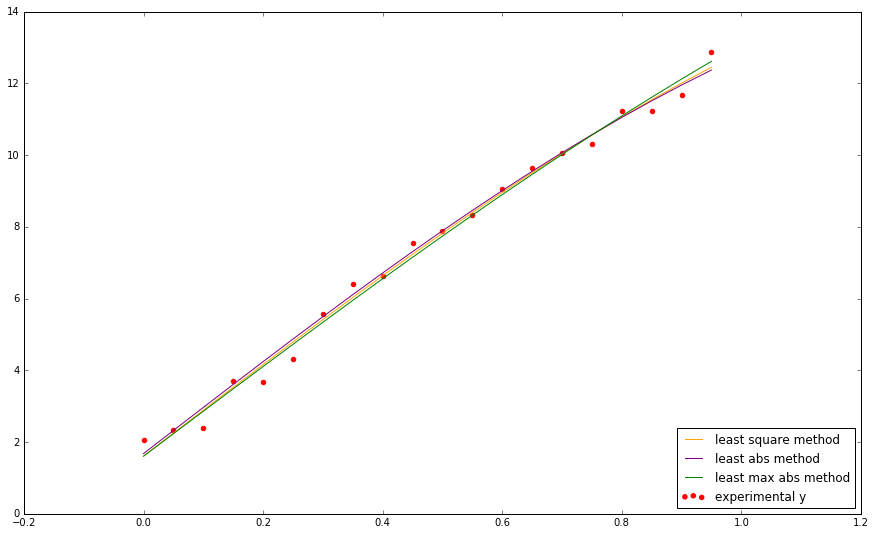

In [1064]:
plt.figure(figsize=(15, 9))
plt.plot(t, result_lsm, label="least square method", color = "orange")
plt.plot(t, result_lam, label="least abs method", color = "purple")
plt.plot(t, result_lmam, label="least max abs method", color = "green")
plt.scatter(t, experimental_y, label="experimental y", color="red")
# plt.scatter(t, original_y, label="original y")
plt.legend(loc="lower right")
plt.show()

Распечатаем полученные коэфициенты:

In [1065]:
print(a_predicted_lmam)
print(a_predicted_lam)
print(a_predicted_lsm)
print(original_a)

[ 1.60518643  5.89080173  6.65481775]
[  1.67834627   1.5172075   11.37297083]
[ 1.60588704  2.93818702  9.90095481]
[1.5, 3, 10]


Запустим серию экспериментов при разных значениях $\sigma$

In [1084]:
def calculate_a(experimental_y, title = ""):

    a_predicted_lsm = estimate_least_squares_method(experimental_y)
    a_predicted_lam = estimate_least_absolute_method(experimental_y)
    a_predicted_lmam = estimate_least_max_absolute_method(experimental_y)
    
    result_lsm = y(t, a_predicted_lsm)
    result_lam = y(t, a_predicted_lam)
    result_lmam = y(t, a_predicted_lmam)
    
    plt.figure(figsize=(15, 9))
    plt.title(title)
    plt.plot(t, result_lsm, label="least square method", color = "orange")
    plt.plot(t, result_lam, label="least abs method", color = "purple")
    plt.plot(t, result_lmam, label="least max abs method", color = "green")
    plt.scatter(t, experimental_y, label="experimental y", color="red")
    # plt.scatter(t, original_y, label="original y")
    plt.legend(loc="lower right")
    plt.show()
    return (a_predicted_lsm, a_predicted_lam, a_predicted_lmam)

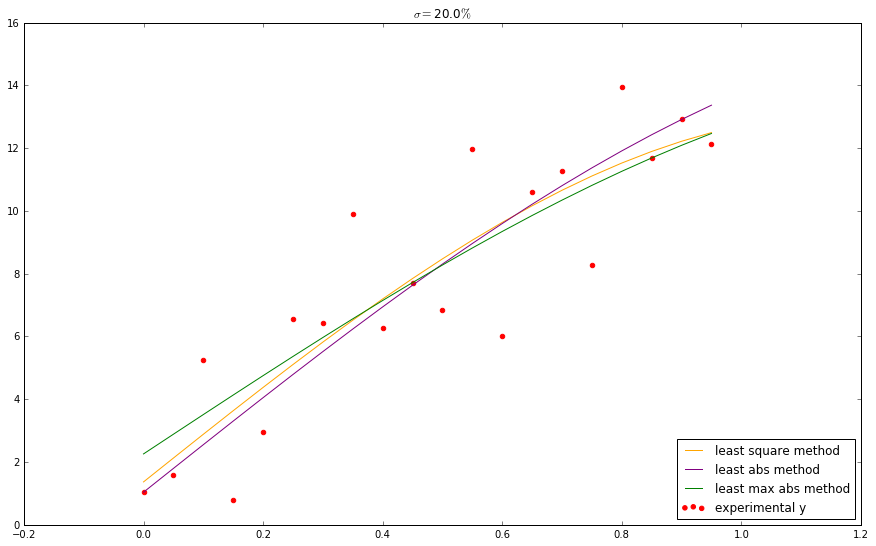

('LSM a:', array([  1.36632395,  -9.12000959,  24.33340093]))
('LAM a:', array([  1.03872184,   0.        ,  15.15920992]))
('LMAM a:', array([  2.25842693,   0.        ,  12.55152099]))
('Original a:', [1.5, 3, 10])


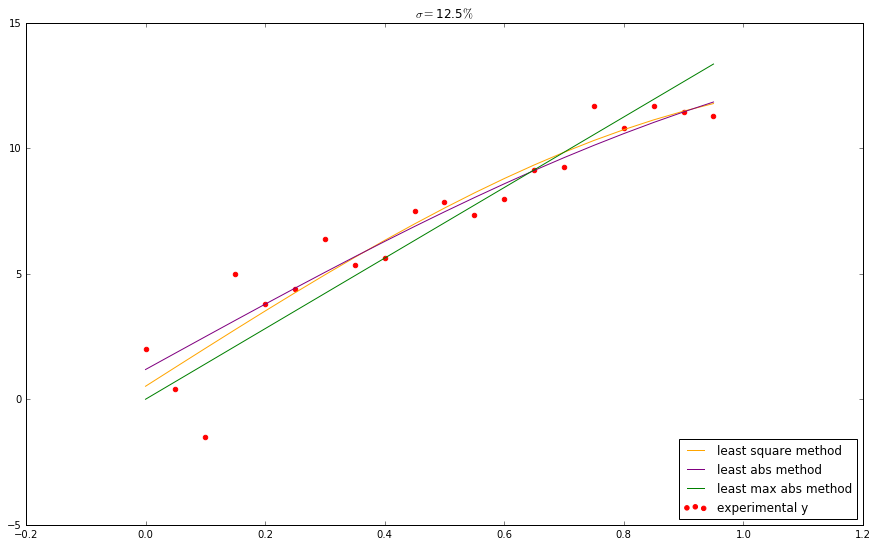

('LSM a:', array([  0.51749877,  -7.67162431,  22.8007225 ]))
('LAM a:', array([  1.18356268,   0.        ,  13.09805921]))
('LMAM a:', array([  0.        ,  14.05237958,   0.        ]))
('Original a:', [1.5, 3, 10])


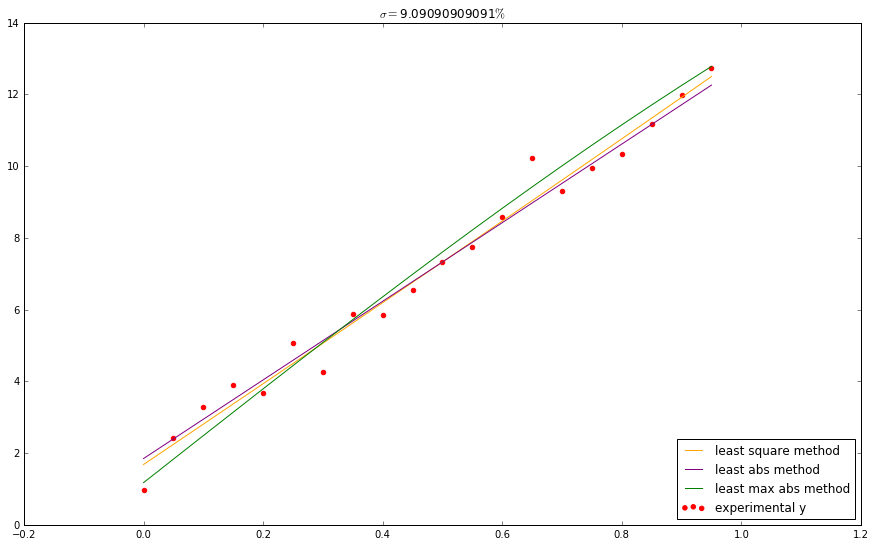

('LSM a:', array([  1.67985341,  12.16061662,  -0.9038591 ]))
('LAM a:', array([  1.84659421,  10.95915086,   0.        ]))
('LMAM a:', array([ 1.17424448,  6.85033102,  6.26637028]))
('Original a:', [1.5, 3, 10])


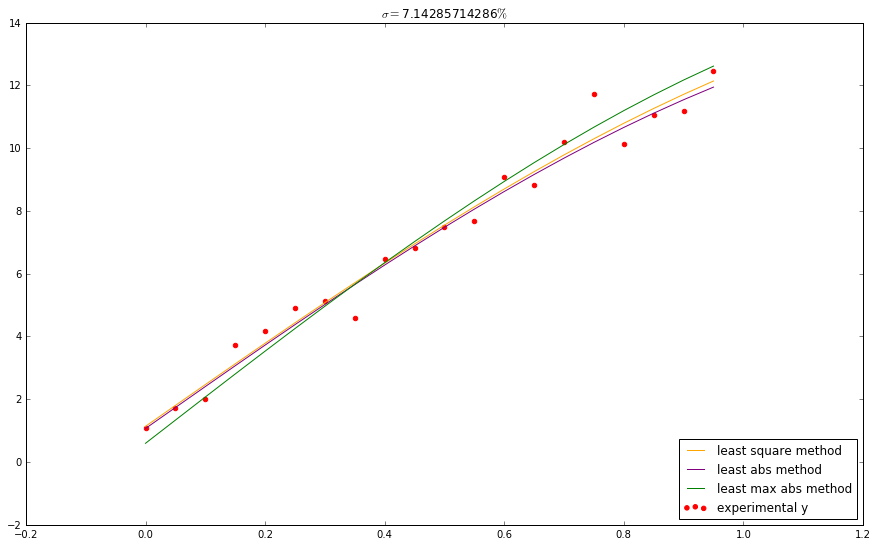

('LSM a:', array([  1.13741122,   1.26183111,  12.05180204]))
('LAM a:', array([  1.06872224,   0.        ,  13.37071546]))
('LMAM a:', array([  0.59677478,   0.        ,  14.7747842 ]))
('Original a:', [1.5, 3, 10])


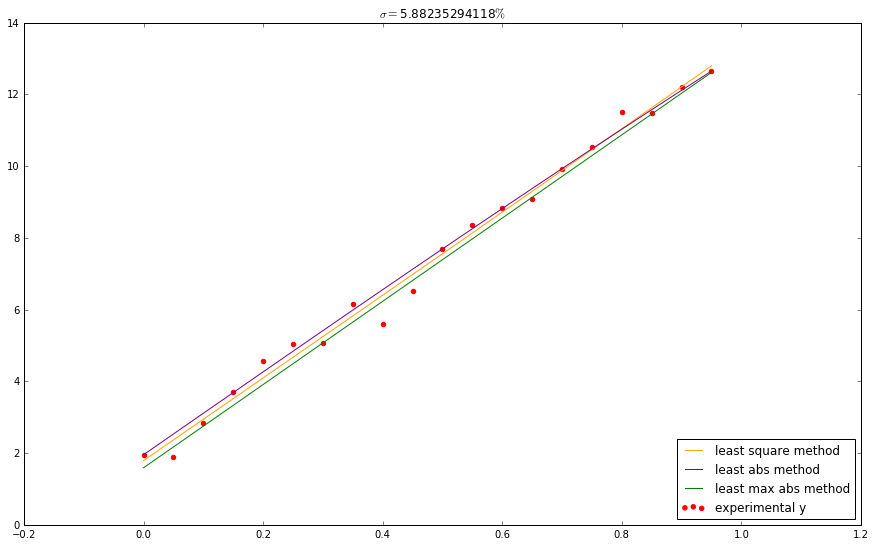

('LSM a:', array([  1.78960393,  12.02540327,  -0.51329443]))
('LAM a:', array([ 1.95312913,  9.45755944,  2.10361483]))
('LMAM a:', array([  1.589223  ,  11.60156351,   0.        ]))
('Original a:', [1.5, 3, 10])


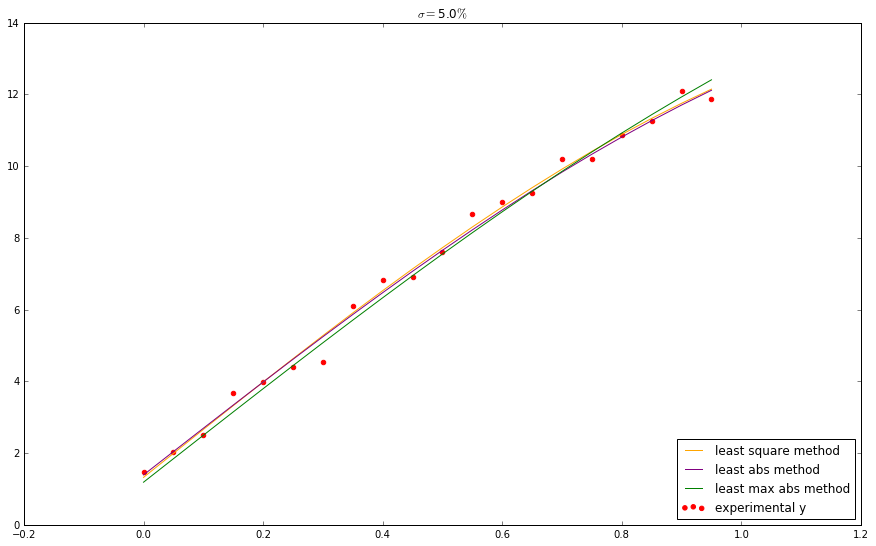

('LSM a:', array([  1.32221503,  -0.41717709,  13.79268091]))
('LAM a:', array([  1.39102902,   0.97821222,  12.03917086]))
('LMAM a:', array([ 1.18756225,  4.18661811,  8.90154133]))
('Original a:', [1.5, 3, 10])


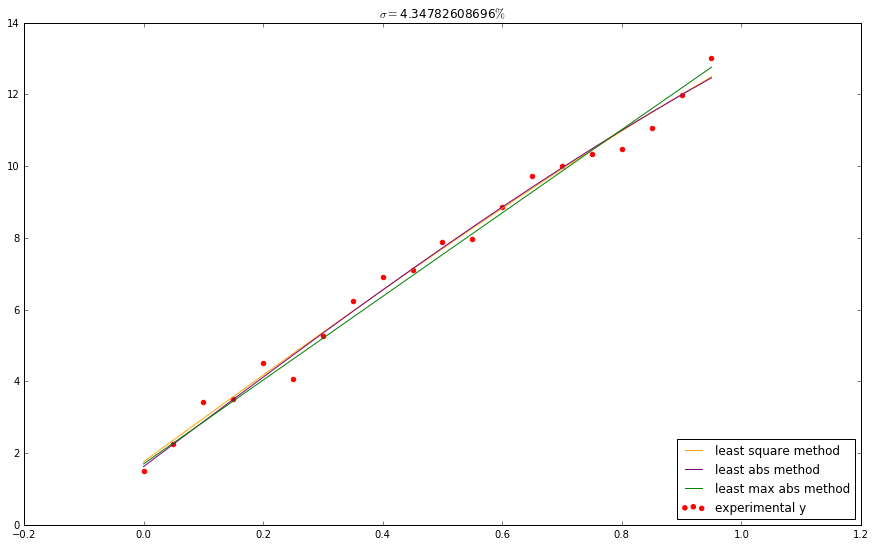

('LSM a:', array([ 1.75488799,  6.40425731,  5.71780304]))
('LAM a:', array([ 1.62274529,  4.83496708,  7.67772317]))
('LMAM a:', array([  1.69723191,  11.41268075,   0.26684784]))
('Original a:', [1.5, 3, 10])


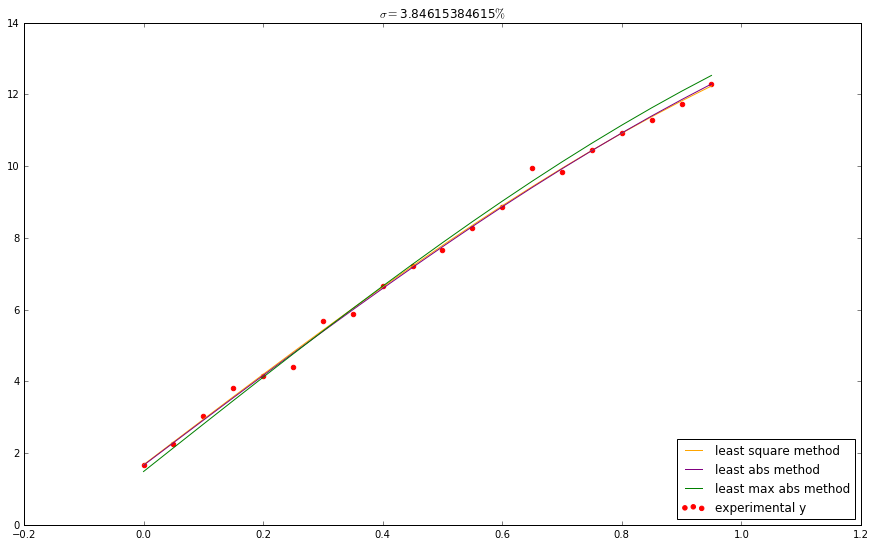

('LSM a:', array([  1.67286962,   1.84830589,  10.82496918]))
('LAM a:', array([ 1.65903597,  2.90648876,  9.67341119]))
('LMAM a:', array([  1.48450344,   2.16212168,  11.05085523]))
('Original a:', [1.5, 3, 10])


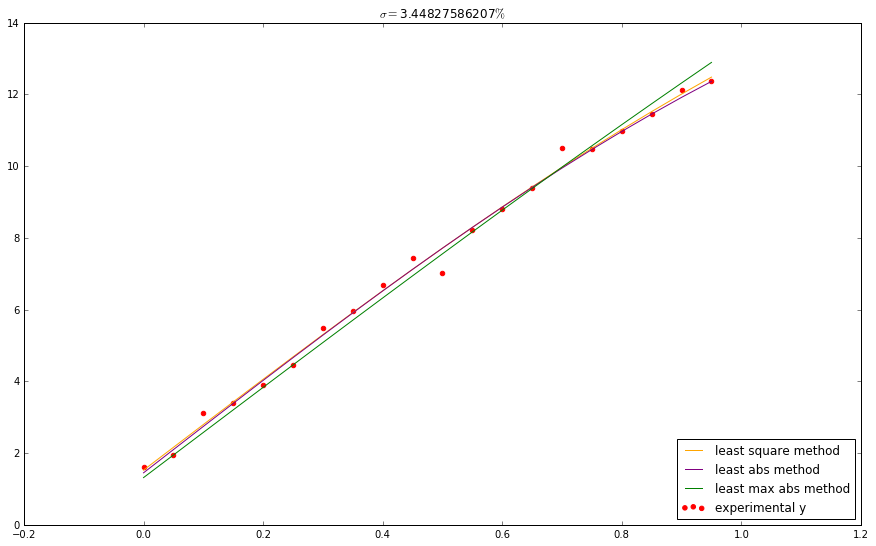

('LSM a:', array([ 1.52406501,  4.51556591,  8.19633857]))
('LAM a:', array([  1.44887086,   2.8181946 ,  10.12423091]))
('LMAM a:', array([ 1.31532016,  9.73936725,  2.85508724]))
('Original a:', [1.5, 3, 10])


In [1088]:
for i in range(5, 30, 3):
    sigma = np.average(np.abs(original_y)) / i
    noise = np.random.normal(0, sigma, len(t))
    experimental_y = original_y + noise
    a_results = calculate_a(experimental_y, "$\sigma = $" + str(100/float(i)) + "$\%$" )
    print("LSM a:", a_results[0])
    print("LAM a:", a_results[1])
    print("LMAM a:", a_results[2])
    print("Original a:", original_a)

Как видно из графиков и значений параметров $a$, метод наименьших квадратов лучше других описывает гаусовый шум в данной задаче.

Сравним, какой из методов более устоичив к выбросам. Еще раз проведем эксперимент с погрешностью $\sigma = 5 \%:$

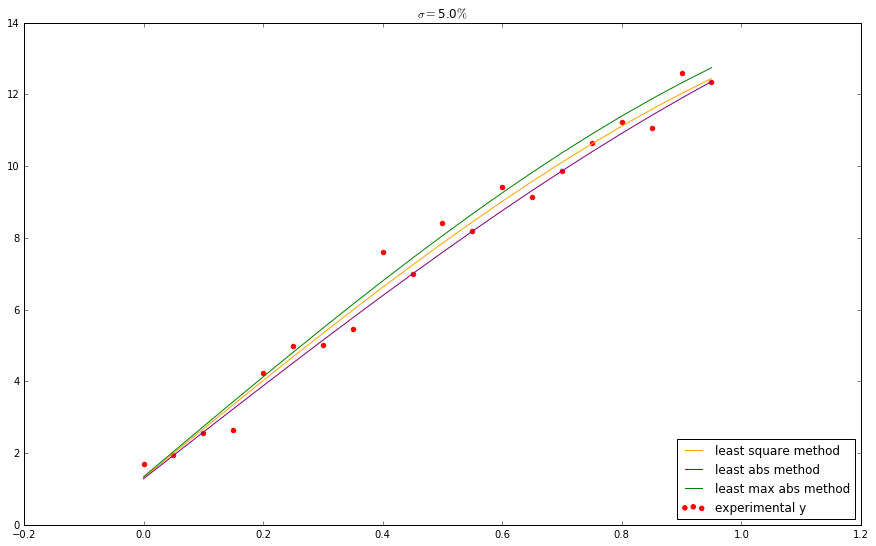

('LSM a:', array([  1.31229723,   0.37694   ,  13.24336149]))
('LAM a:', array([ 1.28309996,  3.58887777,  9.42244069]))
('LMAM a:', array([  1.33803046,   0.        ,  14.01995383]))
('Original a:', [1.5, 3, 10])


In [1089]:
sigma = np.average(np.abs(original_y)) / 20
noise = np.random.normal(0, sigma, len(t))
experimental_y = original_y + noise
a_results = calculate_a(experimental_y, "$\sigma = $" + str(100/float(20)) + "$\%$" )
print("LSM a:", a_results[0])
print("LAM a:", a_results[1])
print("LMAM a:", a_results[2])
print("Original a:", original_a)

Увеличим значение первой и последней попытки эксперимента на $50:$

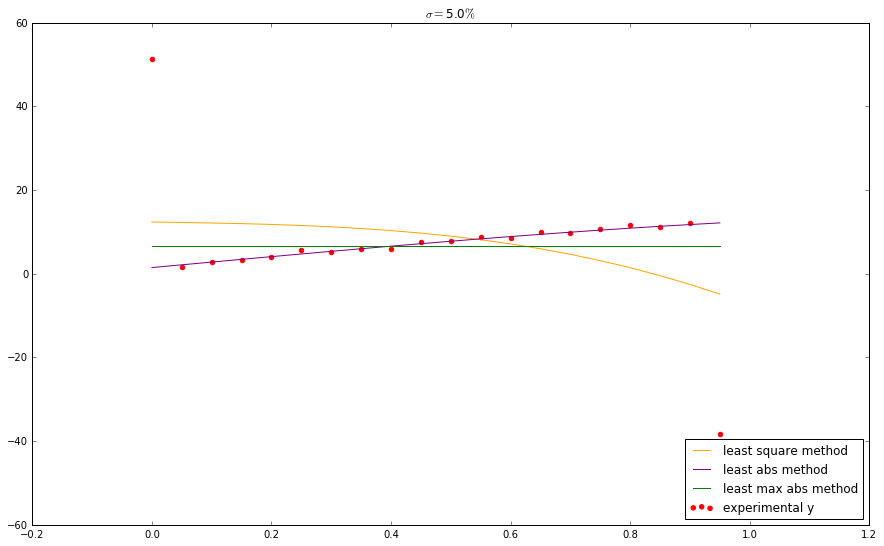

('LSM a:', array([  12.3570144 , -113.10015387,  110.90053363]))
('LAM a:', array([  1.46809386,   0.        ,  13.11970233]))
('LMAM a:', array([ 6.53711513,  0.        ,  0.        ]))
('Original a:', [1.5, 3, 10])


In [1090]:
sigma = np.average(np.abs(original_y)) / 20
noise = np.random.normal(0, sigma, len(t))
experimental_y = original_y + noise
experimental_y[0] += 50
experimental_y[-1] -= 50
a_results = calculate_a(experimental_y, "$\sigma = $" + str(100/float(20)) + "$\%$" )
print("LSM a:", a_results[0])
print("LAM a:", a_results[1])
print("LMAM a:", a_results[2])
print("Original a:", original_a)

В этом случае лучший результат показывает метод минимизации суммы модулей невязок.